In [1]:
import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots
import sklearn.model_selection as skm
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from ISLP import load_data, confusion_table
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (accuracy_score, log_loss)
from sklearn.ensemble import (RandomForestRegressor, RandomForestClassifier)
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz
import shap
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from mpl_toolkits.axes_grid1 import make_axes_locatable
import statistics
import geopandas as gpd
from shapely.geometry import Point
from sklearn.metrics import confusion_matrix
# Help functions
get_country = lambda df,x: df[df["ISO3"]==r"'{}'".format(x)]

def plot_confM(pre_X,Y_test):
    # Calculate the confusion matrix
    #pre_X = mlf1p.predict(X_test)
    #y_pred = clf.predict(pre_X)
    conf_matrix = confusion_matrix(pre_X, Y_test)

    #tick labels, biomes
    bi_vals = set(Y_test) #biome "values" from test data (can also choose traindata)
    bi_vals=list(bi_vals)
    names = [str(item) for item in bi_vals]# x/yticks names
    bi_pos = tuple([index+0.5 for index in range(len(bi_vals))])#(0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5,9.5,10.5,11.5)


    # Plotting confusion
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',cbar=False)#
    plt.xlabel('Predicted', fontsize=14)
    plt.ylabel('Measured', fontsize=14)
    plt.xticks(bi_pos,labels= names, fontsize=12)
    plt.yticks(bi_pos,labels= names, fontsize=12)
    plt.savefig('Multi classifier confusion matrix.png',dpi = 400)
    plt.show()


# data frame

In [4]:
# Main dataframe containing all data
df_main = pd.read_csv('data_index_2.csv')

# Selected features
selected_features1 = ['Lon', 'Lat',
                     'Biome_obs',
                      'ISO3',
        
        'clay', 'silt', 'sand',  'orgC','pH','Biome_Cmax', 'NPP',
                     'SoilR', 'Biome_LAI', 'LitterC','SoilC','VegC',
                     
        'tmax_SpringMean', 
       'tmax_SpringStd', 'tmax_SummerMean', 
       'tmax_SummerStd', 'tmax_FallMean',  'tmax_FallStd',
       'tmax_WinterMean',  'tmax_WinterStd',
                     
       'tswrf_SpringMean', 'tswrf_SpringStd',
       'tswrf_SummerMean',  'tswrf_SummerStd',
       'tswrf_FallMean', 'tswrf_FallStd',
       'tswrf_WinterMean',  'tswrf_WinterStd',
                     
       'tmin_SpringMean',  'tmin_SpringStd',
       'tmin_SummerMean',  'tmin_SummerStd',
       'tmin_FallMean', 'tmin_FallStd', 'tmin_WinterMean','tmin_WinterStd',
                     
        'tmp_SpringMean',
        'tmp_SpringStd', 'tmp_SummerMean',
        'tmp_SummerStd', 'tmp_FallMean', 
       'tmp_FallStd', 'tmp_WinterMean',  'tmp_WinterStd',
                     
       'Pre_SpringMean',  'Pre_SpringStd', 'Pre_SummerMean',
        'Pre_SummerStd', 'Pre_FallMean',
       'Pre_FallStd', 'Pre_WinterMean',  'Pre_WinterStd','Pan_2007']



# Filtering unnecessary variables that we dont want the classifier to use
df = df_main[selected_features1]
#df.columns

In [7]:
# Filtering data from two different regions
df_reg2 = df[(df["Pan_2007"]==r"'{}'".format("China") )|(df["Pan_2007"]==r"'{}'".format("Russia") ) |(df["Pan_2007"]==r"'{}'".format("Europe") )]
df_reg1 = df[(df["Pan_2007"]==r"'{}'".format("Americas") )|(df["Pan_2007"]==r"'{}'".format("Canada") )|(df["Pan_2007"]==r"'{}'".format("USA") )  ]
# Testing data
df_tst = df_reg2
# Training data
df_tr = df_reg1

# Dropping the target variable
biomes = df_tr["Biome_obs"]
biomes_train = biomes.to_numpy()
df_train=df_tr.drop(["Biome_obs","ISO3","Pan_2007"],axis= 1)

biomes_test = df_tst["Biome_obs"]
biomes_test = biomes_test.to_numpy()
df_test = df_tst.drop(["Biome_obs","ISO3","Pan_2007"],axis= 1)


# Plotting

18


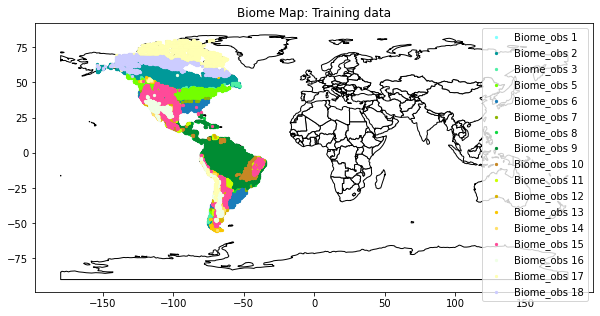

In [444]:
dataframe = df_tr
# Extract longitude, latitude, and biome_obs columns
longitude = dataframe['Lon']
latitude = dataframe['Lat']
biome = dataframe['Biome_obs']


# Combine longitude and latitude into a GeoDataFrame
geometry = [Point(lon, lat) for lon, lat in zip(longitude, latitude)]
gdf = gpd.GeoDataFrame(dataframe, geometry=geometry)
biome_colors = {
    1: (0.5, 1, 1),    # Red
    2: (0, 0.6, 0.6),    # Blue
    3: (0.31, 0.94, 0.65),    # Green
    4: (0.8, 1, 0.84),
    5: (0.45, 1, 0),
    6: (0.1, 0.49, 0.73),
    7: (0.55, 0.71, 0),
    8: (0.05, 0.85, 0.25),
    9: (0, 0.55, 0.2),
    10: (0.78, 0.53, 0.14),
    11: (0.8, 1, 0),
    12: (0.85, 0.7, 0),
    13: (0.98, 0.78, 0),
    14: (1, 0.88, 0.41),
    15: (1, 0.29, 0.6),
    16: (0.94, 1, 0.9),
    17: (1, 1, 0.7),
    18: (0.8, 0.8, 1)
    # Add more colors for other biomes using RGB values
}


# Create a base map
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
ax = world.plot(figsize=(10, 10), color='white', edgecolor='black')

# Plot points with different colors based on biome
for b in set(biome):
    gdf_b = gdf[gdf['Biome_obs'] == b]
    gdf_b.plot(ax=ax, color=biome_colors[b], label=f'Biome_obs {b}', markersize=5)
print(b)
# Add legend
plt.legend()

# Add a title
plt.title('Biome Map: Training data')

# Show the map
plt.show()


18


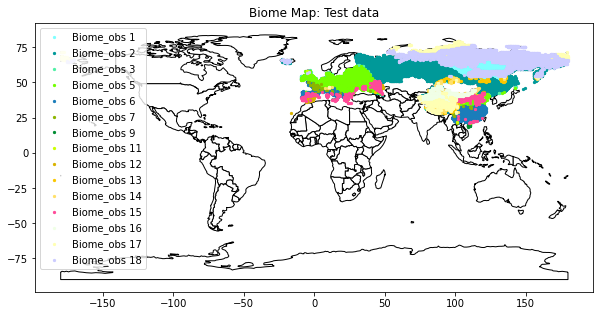

In [380]:
dataframe = df_tst
# Extract longitude, latitude, and biome_obs columns
longitude = dataframe['Lon']
latitude = dataframe['Lat']
biome = dataframe['Biome_obs']


# Combine longitude and latitude into a GeoDataFrame
geometry = [Point(lon, lat) for lon, lat in zip(longitude, latitude)]
gdf = gpd.GeoDataFrame(dataframe, geometry=geometry)



# Create a base map
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
ax = world.plot(figsize=(10, 10), color='white', edgecolor='black')

# Plot points with different colors based on biome
for b in set(biome):
    gdf_b = gdf[gdf['Biome_obs'] == b]
    gdf_b.plot(ax=ax, color=biome_colors[b], label=f'Biome_obs {b}', markersize=5)
print(b)
# Add legend
plt.legend()

# Add a title
plt.title('Biome Map: Test data')

# Show the map
plt.show()


## Random Forest classifier

In [11]:
# initiate a fitting model (RandomForest)
clf = RandomForestClassifier(random_state=0,n_estimators = 140)
clf.fit(df_train, biomes_train)

RandomForestClassifier(n_estimators=140, random_state=0)

In [12]:
accuracy_score(biomes_train, clf.predict(df_train))

1.0

In [13]:
clf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 140,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 0,
 'verbose': 0,
 'warm_start': False}

In [14]:
feature_names = list(df_train.columns)
tree_index_to_visualize = 1
dot_data = export_graphviz(clf.estimators_[tree_index_to_visualize],
                feature_names=feature_names,
                filled=True,
                rounded=True)
graph = graphviz.Source(dot_data)
#display(graph)

## Calculating test and training data acuracy 

In [15]:
# data
X_train = df_train
X_test = df_test
Biome_train =biomes_train
Biome_test = biomes_test
# Cross validation
kfold = skm.KFold(3,
                  random_state=1,
                  shuffle=True)
clf.fit(X_train, Biome_train)
pre_x = clf.predict(X_test)
score_rfc_train = accuracy_score(Biome_train, clf.predict(X_train))
print('Accuracy of RandomForestClassifier on train data: {:.4f}'.format(score_rfc_train))

scores_rfc_val = cross_val_score(clf, X_train, Biome_train, cv=kfold)
print("Accuracy RandomForestClassifier on cross validation: %0.4f ( %0.2f)" % (scores_rfc_val.mean(), scores_rfc_val.std()))

score_rfc_test = accuracy_score(Biome_test, clf.predict(X_test))
print('Accuracy of RandomForestClassifier on test data: {:.4f}'.format(score_rfc_test))



Accuracy of RandomForestClassifier on train data: 1.0000
Accuracy RandomForestClassifier on cross validation: 0.9247 ( 0.00)
Accuracy of RandomForestClassifier on test data: 0.9002


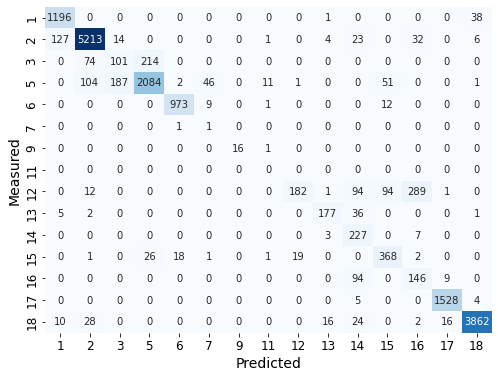

In [16]:
plot_confM(pre_x,Biome_test)

## Fine tuning hyper parameters

In [ ]:
kfold3 = skm.KFold(3,
                  random_state=1,
                  shuffle=True) # let's try fewer fold to save running time
n_depths_range = np.linspace(1, 30, 10).astype('int')
n_estimators_range = np.array([25])#np.linspace(10, 100, 10).astype('int') # CV number of trees (estimators) 10, 20, ..., 100

params = {
    'max_depth': n_depths_range, # let's tune for only one parameters to save running time
    'n_estimators': n_estimators_range,
     }
rfc_gscv = GridSearchCV(clf, param_grid = params, scoring = "accuracy",
                             cv = kfold3 )
# Fit the model
model_rfc = rfc_gscv.fit(X_train, High_train)

# Model best estimator
max_depths=model_rfc.best_estimator_.get_params()["max_depth"]
max_trees= model_rfc.best_estimator_.get_params()["n_estimators"]
max_cvs= rfc_gscv.best_score_
print("Max Depth: ", max_depths)
print("Max Trees: ",max_trees)
print("Max CV: ",max_cvs)

In [386]:
kfold3 = skm.KFold(3,
                  random_state=1,
                  shuffle=True) # let's try fewer fold to save running time

import time

# Start the timer

def fine(n):
    clft = RandomForestClassifier(random_state=0,n_estimators=n)
    score = cross_val_score(clft, X_train, Biome_train, cv=kfold3)
    return round(np.mean(score),5)
start_time = time.time()

end_time = time.time()

elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time} seconds")


Elapsed time: 0.0 seconds


In [387]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
# Example data
#d = np.array([1,2,3,4,5,6,7,8,9,10])  # Row values
n = np.array([10,20,40,60,80,100,120,140,160,180,200])  # Column values

# Example heatmap data (you can replace this with your actual data)

# Initialize an array to store the results
Z = np.zeros(n.shape)

for i in tqdm(range(len(n)), desc="Progress", ncols=100):
        Z[i] = fine( n[i])
# Create a colormap


Progress: 100%|█████████████████████████████████████████████████████| 11/11 [11:53<00:00, 64.87s/it]


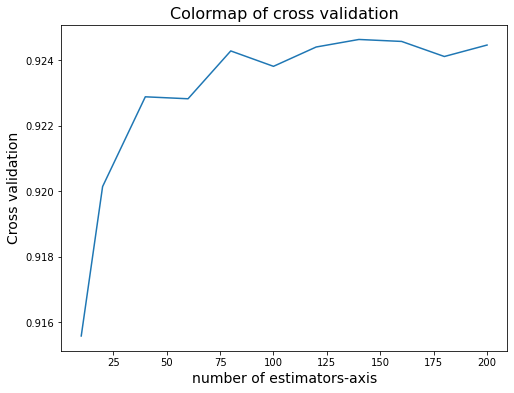

In [388]:
plt.figure(figsize=(8, 6))
plt.plot(n,Z)



# Add labels and title
plt.xlabel('number of estimators-axis', fontsize=14)
plt.ylabel('Cross validation', fontsize=14)
plt.title('Colormap of cross validation', fontsize=16)
plt.savefig('parameter search CV multi.png', dpi = 400)
plt.show()

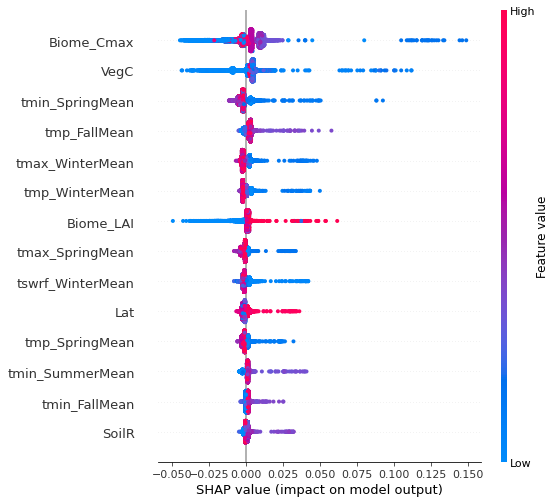

In [38]:
shap_values = shap.TreeExplainer(clf).shap_values(X_train)
shap.summary_plot(shap_values[0], X_train,show=False,max_display=14)
plt.savefig('shap multi classifier.png',dpi = 400)
plt.show()

# Plotting predictions

In [28]:
predictions = [Biome_test[i]==pre_x[i] for i in range(len(pre_x))]
predictions =  [int(x) for x in predictions]

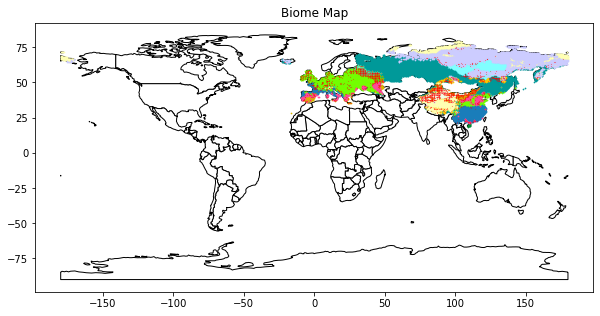

In [37]:

dataframe = df_test
# Extract longitude, latitude, and biome_obs columns
longitude = dataframe['Lon']
latitude = dataframe['Lat']
biome = pre_x
df_test['Biome_obs']= pre_x
df_test['pre_x'] = predictions


# Combine longitude and latitude into a GeoDataFrame
geometry = [Point(lon, lat) for lon, lat in zip(longitude, latitude)]
gdf = gpd.GeoDataFrame(dataframe, geometry=geometry)
biome_colors = {
    1: (0.5, 1, 1),    # Red
    2: (0, 0.6, 0.6),    # Blue
    3: (0.31, 0.94, 0.65),    # Green
    4: (0.8, 1, 0.84),
    5: (0.45, 1, 0),
    6: (0.1, 0.49, 0.73),
    7: (0.55, 0.71, 0),
    8: (0.05, 0.85, 0.25),
    9: (0, 0.55, 0.2),
    10: (0.78, 0.53, 0.14),
    11: (0.8, 1, 0),
    12: (0.85, 0.7, 0),
    13: (0.98, 0.78, 0),
    14: (1, 0.88, 0.41),
    15: (1, 0.29, 0.6),
    16: (0.94, 1, 0.9),
    17: (1, 1, 0.7),
    18: (0.8, 0.8, 1)
    # Add more colors for other biomes using RGB values
}


# Create a base map
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
ax = world.plot(figsize=(10, 10), color='white', edgecolor='black')

# Plot points with different colors based on biome
for b in set(biome):
    gdf_b = gdf[gdf['Biome_obs'] == b]
    gdf_b.plot(ax=ax, color=biome_colors[b], label=f'Biome_obs {b}', markersize=0.5)
gdfb = gdf_b = gdf[gdf['pre_x'] == 0]
gdf_b.plot(ax=ax, color=(1,0,0), label='false predictions',marker='x', markersize=0.01)
    

plt.savefig('false pred.png',dpi = 600)
# Add a title
plt.title('Biome Map')

# Show the map
plt.show()


# Feature importance

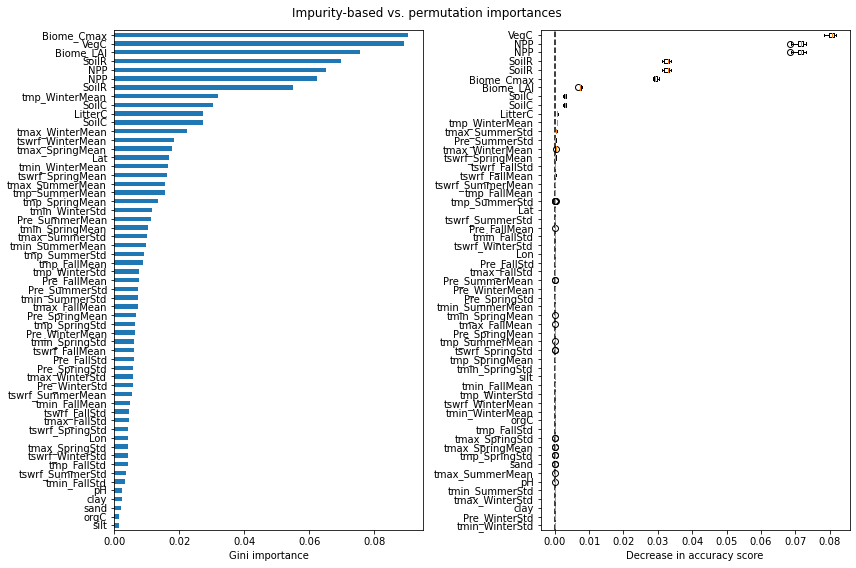

In [389]:
from sklearn.inspection import permutation_importance


def plot_permutation_importance(clf, X, y, ax):
    result = permutation_importance(clf, X, y, n_repeats=10, random_state=0, n_jobs=2)
    perm_sorted_idx = result.importances_mean.argsort()

    ax.boxplot(
        result.importances[perm_sorted_idx].T,
        vert=False,
        labels=X.columns[perm_sorted_idx],
    )
    ax.axvline(x=0, color="k", linestyle="--")
    return ax


mdi_importances = pd.Series(clf.feature_importances_, index=X_train.columns)
tree_importance_sorted_idx = np.argsort(clf.feature_importances_)
tree_indices = np.arange(0, len(clf.feature_importances_)) + 0.5



KeyboardInterrupt: 

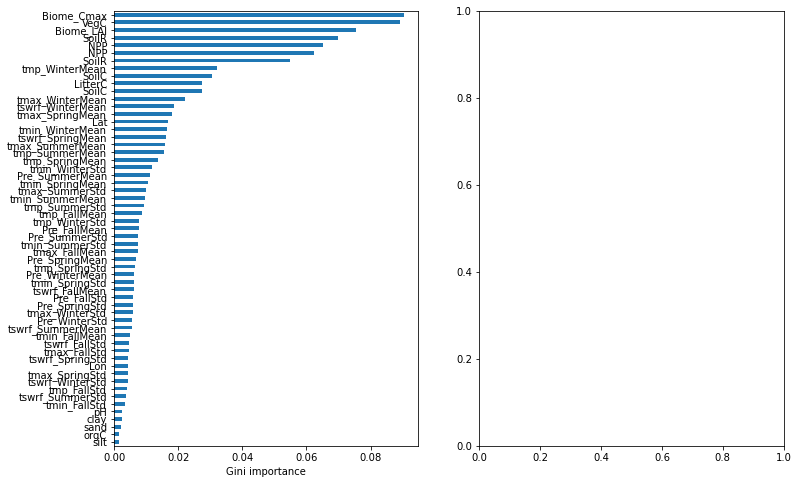

In [390]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
mdi_importances.sort_values().plot.barh(ax=ax1)
ax1.set_xlabel("Gini importance")
plot_permutation_importance(clf, X_train, Biome_train, ax2)
ax2.set_xlabel("Decrease in accuracy score")
fig.suptitle(
    "Impurity-based vs. permutation importances "
)
_ = fig.tight_layout()
plt.savefig('feature importance multi class.png',dpi=400)

# Dealing with colinear features

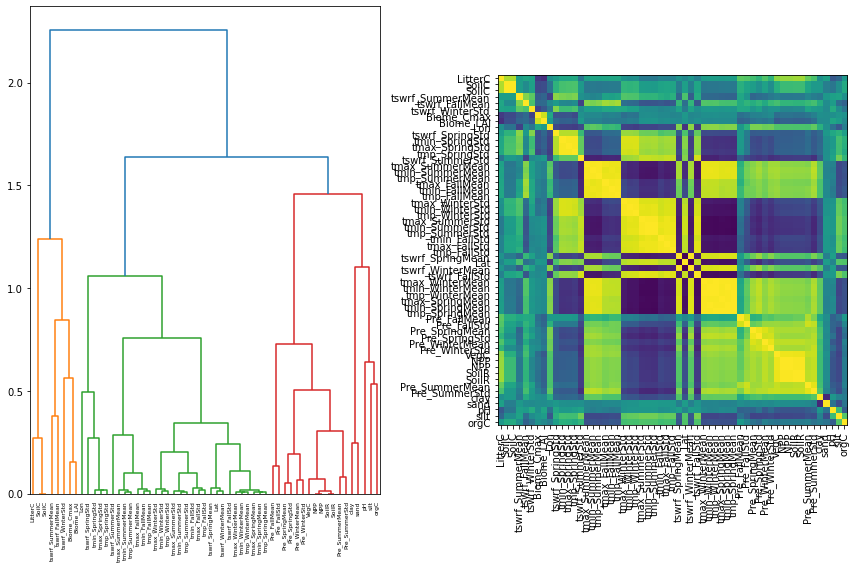

In [391]:
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform
from scipy.stats import spearmanr

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
corr = spearmanr(X_train).correlation

# Ensure the correlation matrix is symmetric
corr = (corr + corr.T) / 2
np.fill_diagonal(corr, 1)

# We convert the correlation matrix to a distance matrix before performing
# hierarchical clustering using Ward's linkage.
distance_matrix = 1 - np.abs(corr)
dist_linkage = hierarchy.ward(squareform(distance_matrix))
dendro = hierarchy.dendrogram(
    dist_linkage, labels=X_train.columns.to_list(), ax=ax1, leaf_rotation=90
)
dendro_idx = np.arange(0, len(dendro["ivl"]))

ax2.imshow(corr[dendro["leaves"], :][:, dendro["leaves"]])
ax2.set_xticks(dendro_idx)
ax2.set_yticks(dendro_idx)
ax2.set_xticklabels(dendro["ivl"], rotation="vertical")
ax2.set_yticklabels(dendro["ivl"])
_ = fig.tight_layout()
plt.savefig('col.png', dpi=400, bbox_inches='tight')

In [33]:
plt.show()

In [426]:
from collections import defaultdict

cluster_ids = hierarchy.fcluster(dist_linkage, 0.005, criterion="distance")
cluster_id_to_feature_ids = defaultdict(list)


In [427]:
for idx, cluster_id in enumerate(cluster_ids):
    cluster_id_to_feature_ids[cluster_id].append(idx)
selected_features = [v[0] for v in cluster_id_to_feature_ids.values()]
selected_features_names = X_train.columns[selected_features]
L = []
for v in cluster_id_to_feature_ids.values():
    print("Cluster ", X_train.columns[v])

Cluster  Index(['Lon'], dtype='object')
Cluster  Index(['Lat'], dtype='object')
Cluster  Index(['clay'], dtype='object')
Cluster  Index(['silt'], dtype='object')
Cluster  Index(['sand'], dtype='object')
Cluster  Index(['orgC'], dtype='object')
Cluster  Index(['pH'], dtype='object')
Cluster  Index(['Biome_Cmax'], dtype='object')
Cluster  Index(['NPP', 'NPP'], dtype='object')
Cluster  Index(['SoilR', 'SoilR'], dtype='object')
Cluster  Index(['Biome_LAI'], dtype='object')
Cluster  Index(['LitterC'], dtype='object')
Cluster  Index(['SoilC', 'SoilC'], dtype='object')
Cluster  Index(['tmax_SpringMean'], dtype='object')
Cluster  Index(['tmax_SpringStd'], dtype='object')
Cluster  Index(['tmax_SummerMean'], dtype='object')
Cluster  Index(['tmax_SummerStd'], dtype='object')
Cluster  Index(['tmax_FallMean'], dtype='object')
Cluster  Index(['tmax_FallStd'], dtype='object')
Cluster  Index(['tmax_WinterMean'], dtype='object')
Cluster  Index(['tmax_WinterStd'], dtype='object')
Cluster  Index(['tswrf_

In [428]:
for idx, cluster_id in enumerate(cluster_ids):
    cluster_id_to_feature_ids[cluster_id].append(idx)
selected_features = [v[0] for v in cluster_id_to_feature_ids.values()]
selected_features_names = X_train.columns[selected_features]

X_train_sel = X_train[selected_features_names]
X_test_sel = X_test[selected_features_names]

clf_sel = RandomForestClassifier(n_estimators=100, random_state=42)
clf_sel.fit(X_train_sel, Biome_train)
print(
    "Baseline accuracy on test data with features removed:"
    f" {clf_sel.score(X_test_sel, Biome_test):.2}"
)

Baseline accuracy on test data with features removed: 0.91


In [429]:
selected_features_names

Index(['Lon', 'Lat', 'clay', 'silt', 'sand', 'orgC', 'pH', 'Biome_Cmax', 'NPP',
       'SoilR', 'Biome_LAI', 'LitterC', 'SoilC', 'tmax_SpringMean',
       'tmax_SpringStd', 'tmax_SummerMean', 'tmax_SummerStd', 'tmax_FallMean',
       'tmax_FallStd', 'tmax_WinterMean', 'tmax_WinterStd', 'tswrf_SpringMean',
       'tswrf_SpringStd', 'tswrf_SummerMean', 'tswrf_SummerStd',
       'tswrf_FallMean', 'tswrf_FallStd', 'tswrf_WinterMean',
       'tswrf_WinterStd', 'tmin_SpringMean', 'tmin_SpringStd',
       'tmin_SummerMean', 'tmin_SummerStd', 'tmin_FallMean', 'tmin_FallStd',
       'tmin_WinterMean', 'tmin_WinterStd', 'tmp_SpringMean', 'tmp_SpringStd',
       'tmp_SummerMean', 'tmp_SummerStd', 'tmp_FallMean', 'tmp_FallStd',
       'tmp_WinterMean', 'tmp_WinterStd', 'Pre_SpringMean', 'Pre_SpringStd',
       'Pre_SummerMean', 'Pre_SummerStd', 'Pre_FallMean', 'Pre_FallStd',
       'Pre_WinterMean', 'Pre_WinterStd', 'VegC'],
      dtype='object')

In [ ]:
fig, ax = plt.subplots(figsize=(7, 6))
plot_permutation_importance(clf_sel, X_test_sel, Biome_test, ax)
ax.set_title("Permutation Importances on selected subset of features\n(test set)")
ax.set_xlabel("Decrease in accuracy score")
ax.figure.tight_layout()
plt.savefig('permutation importance multi classifier selected features.png',dpi=400)
plt.show()